<a href="https://colab.research.google.com/github/aniketmaurya/pytorch-gans/blob/main/DCGAN/dcgan_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DC-GAN

**Paper: Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks**

**Link: https://arxiv.org/abs/1511.06434**

**Authors: Alec Radford, Luke Metz, Soumith Chintala**

## Abstract
In recent years, supervised learning with convolutional networks (CNNs) has seen huge adoption in computer vision applications. Comparatively, unsupervised learning with CNNs has received less attention. In this work we hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning. We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning. Training on various image datasets, we show convincing evidence that our deep convolutional adversarial pair learns a hierarchy of representations from object parts to scenes in both the generator and discriminator. Additionally, we use the learned features for novel tasks - demonstrating their applicability as general image representations.


# What is DCGAN?
DCGAN (Deep Convolutional Generative Adversarial Network) is created by Alec Radford, Luke Metz and Soumith Chintala in 2016 to train Deep Generative Adversarial Networks. In the [DCGAN paper](https://arxiv.org/abs/1511.06434), the authors trained the network to produce fake faces of celebrities and fake bedroom images.

The architecture consists of two networks - Generator and Discriminator. Generator is the heart of GANs. It produces real looking fake images from random noise. 

Discriminator wants the real and fake image distributions to be as far as possible while the Generator wants to reduce the distance between the real and fake image distribution.
In simple words, the Generator tries to fool the Discriminator by producing real looking images while the Discriminator tries to catch the fake images from the real ones.



| ![Picture from paper](https://raw.githubusercontent.com/aniketmaurya/ml-resources/master/images/dcgan-vector-arithmetic.png) |
| :-: |
| *Vector arithmetic for visual concepts. Source: Paper* |

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install pytorch-lightning -q

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from tqdm.notebook import tqdm

from glob import glob
import matplotlib.pyplot as plt

import pytorch_lightning as pl

### [Optional] 
CelebA dataset is available on Kaggle and torchvision datasets but the latter sometimes doesn't work.
Run the code below if you want to download dataset from Kaggle.


First you will have to load your kaggle key at /root/.kaggle/kaggle.json

In [ ]:
# run this if want to train on kaggle dataset
# copy kaggle key to /root/.kaggle/kaggle.json

import os
os.makedirs('/root/.kaggle')
!cp ./kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -qq ./celeba-dataset.zip
path = './img_align_celeba/img_align_celeba'

 99% 1.31G/1.33G [00:07<00:00, 228MB/s]
100% 1.33G/1.33G [00:07<00:00, 181MB/s]


In [ ]:
def show_tensor_images(image_tensor,
                       num_images=25,
                       size=(3, 64, 64),
                       ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Training details from the paper
**Preprocessing**: Images are scaled to be in range of tanh activation, [-1, 1].
Training was done with a mini-batch size of 128 and Adam optimizer with a learning rate of 0.0002.
All the weights initialised with Normal distribution $\mu(0, 0.02)$.

**Authors guidelines:**
- All the pooling layers are replaced with strided convolutions.
- No fully-connected or pooling layers are used.
- Batchnorm used in both Generator and Discriminator
- ReLu activation is used for generator for all the layers except the last layer which uses tanh
- Discriminator uses LeakyReLu for all the layers

In [ ]:
# Configurations are from DCGAN paper
z_dim = 100
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999

display_step = 500
device = "cuda"

### Create dataloader

In [ ]:
from PIL import Image

In [ ]:
# You can tranform the image values to be between -1 and 1
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Run this if want to load kaggle dataset

class ImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = glob(f'{path}/*')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        label = file.split('/')[-1]
        image = Image.open(file)
        if self.transform:
            image = self.transform(image)
        return image, label


ds = ImageDataset(path, transform=transform)
dataloader = dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [ ]:
# Run this if you want to use Pytorch datasets

# ds = datasets.CelebA('.',
#                     download=True,
#                     transform=transform)
# dataloader = dl = DataLoader(ds,
#                              batch_size=batch_size,
#                              shuffle=True)

# Network

GANs are made up of two entities - Generator and Discriminator.

## Generator
Generator learns the data distribution and creates fake images.

> A Generator consists Transposed Convolution, Batch Normalisation and activation function layer.

- First the random noise of size 100 will be reshaped to 100x1x1 (channel first in PyTorch).
- It is passed through a Transposed CNN layer which upsamples the input Tensor.
- Batch Normalisation is applied.
- If the layer is not the last layer then ReLu activation is applied else Tanh.

In [ ]:
def get_noise(cur_batch_size, z_dim):
    noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
    return noise

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, z_dim=100):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.create_upblock(z_dim,
                                1024,
                                kernel_size=4,
                                stride=1,
                                padding=0),
            self.create_upblock(1024, 512, kernel_size=4, stride=2, padding=1),
            self.create_upblock(512, 256, kernel_size=4, stride=2, padding=1),
            self.create_upblock(256, 128, kernel_size=4, stride=2, padding=1),
            self.create_upblock(128,
                                3,
                                kernel_size=4,
                                stride=2,
                                padding=1,
                                final_layer=True),
        )

    def create_upblock(self,
                       in_channels,
                       out_channels,
                       kernel_size=5,
                       stride=2,
                       padding=1,
                       final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels,
                                   out_channels,
                                   kernel_size,
                                   stride,
                                   padding,
                                   bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Tanh()
                )
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True))

    def forward(self, noise):
        """
        noise: random vector of shape=(N, 100, 1, 1)
        """
        assert len(noise.shape) == 4, 'random vector of shape=(N, 100, 1, 1)'

        return self.gen(noise)

# Discriminator

The architecture of a Discriminator is same as that of a normal image classification model.

It contains Convolution layers, Activation layer and BatchNormalisation.

In the DCGAN paper, strides are used instead of pooling to reduce the size of a kernel. Also there is no Fully Connected layer in the network. Leaky ReLU with leak slope 0.2 is used.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, stride=1),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 4, stride=2),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self,
                        input_channels,
                        output_channels,
                        kernel_size=4,
                        stride=2,
                        final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size,
                          stride), nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2))
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size,
                          stride))

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
# disc = Discriminator()
# disc(torch.randn(10, 3, 64, 64)).shape

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training Loop

Binary Crossentropy loss is used for training DCGAN.

### Discriminator Loss
As the discriminator wants to increase the distance between Generated and Real distribution, we will train it to give high loss when the generated images is classified as real or when real images are classified as fake.

### Generator Loss
The BCE loss for Generator will be high when it fails to fool the Discriminator. It will give high loss when the generated image is classified as fake by the discriminator. Note that the Generator never know about real images.



# WHAT IS PYTORCH LIGHTNING?
> **Lightning makes coding complex networks simple.
Spend more time on research, less on engineering. It is fully flexible to fit any use case and built on pure PyTorch so there is no need to learn a new language.**

*A quick refactor will allow you to:*
- Run your code on any hardware
- Performance & bottleneck profiler
- Model checkpointing
- 16-bit precision
- Run distributed training
- Logging
- Metrics
- Visualization
- Early stopping
- ... and many more!

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self,
                 learning_rate,
                 in_channels=3,
                 hidden_dim=32,
                 z_dim=100,
                 **kwargs):
        super().__init__()

        self.z_dim = z_dim
        self.learning_rate = learning_rate

        self.save_hyperparameters()

        self.gen = Generator(in_channels, z_dim=z_dim)
        self.disc = Discriminator(im_chan=in_channels,
                                  hidden_dim=hidden_dim)

        self.gen.apply(weights_init)
        self.disc.apply(weights_init)

    def forward(self, noise):
        # in lightning, forward defines the prediction/inference actions
        return self.gen(noise)

    def disc_step(self, x, noise):
        """
        x: real image
        """
        fake_images = self.gen(noise)
        # get discriminator outputs
        real_logits = self.disc(x)
        fake_logits = self.disc(fake_images.detach())
        assert real_logits.shape == fake_logits.shape, f"Real and fake logit shape are different: {real_logits.shape} and {fake_logits.shape}"

        # real loss
        real_loss = criterion(real_logits, torch.ones_like(real_logits))
        # fake loss
        fake_loss = criterion(fake_logits, torch.zeros_like(fake_logits))
        disc_loss = (fake_loss + real_loss) / 2

        assert disc_loss is not None
        self.log('disc_loss', disc_loss, on_epoch=True, prog_bar=True)
        return disc_loss

    def gen_step(self, x, noise):
        # generate fake images
        fake_images = self.gen(noise)

        fake_logits = self.disc(fake_images)
        fake_loss = criterion(fake_logits, torch.ones_like(fake_logits))

        gen_loss = fake_loss

        assert gen_loss is not None
        self.log('gen_loss', gen_loss, on_epoch=True, prog_bar=True)
        return gen_loss

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, _ = batch
        x = real = x
        noise = get_noise(real.shape[0], self.z_dim)
        assert real.shape[1:] == (
            3, 64, 64), f"batch image data shape is incorrect: {real.shape}"

        if batch_idx % display_step == 0 and optimizer_idx == 0:
            fake_images = self.forward(noise)

            show_tensor_images(fake_images)
            # show_tensor_images(real)

        loss = 0.0
        # first get gen loss [opt_g, opt_d]
        if optimizer_idx == 0:
            loss = self.gen_step(real, noise)

        elif optimizer_idx == 1:
            loss = self.disc_step(real, noise)
        return loss

    def configure_optimizers(self):
        lr = self.hparams.learning_rate

        opt_g = torch.optim.Adam(self.gen.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        opt_d = torch.optim.Adam(self.disc.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        return [opt_g, opt_d]

In [ ]:
model = GAN(learning_rate=lr, z_dim=z_dim)
trainer = pl.Trainer(max_epochs=20, gpus=1)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 12.7 M
1 | disc | Discriminator | 430 K 
---------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params


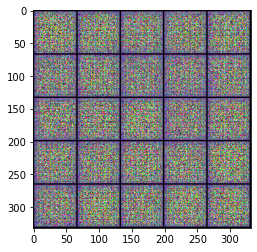

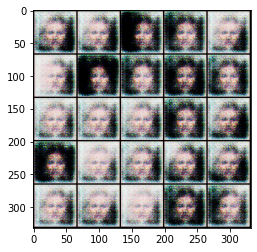

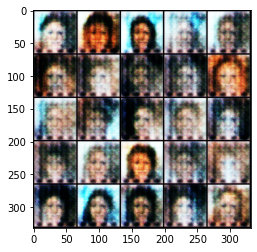

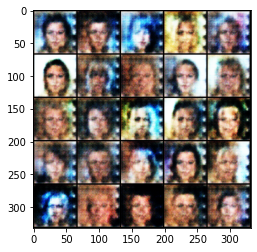

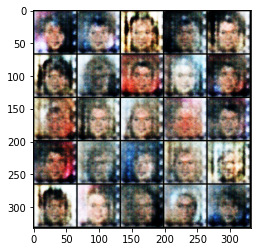

In [ ]:
trainer.fit(model, dl)